In [229]:
import os
import re
import nltk
from nltk.stem import WordNetLemmatizer
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.svm import LinearSVC
from sklearn.svm import SVC


# Get and format data

In [199]:
dir_path = os.path.abspath('')

data_dir = os.path.join(dir_path, "../../data/expressive/")

text_data = os.path.join(data_dir, f"raw_text_anonymized.csv")
label_data = os.path.join(data_dir, f"brief_survey_anonymized.csv")

text_df = pd.read_csv(text_data)
label_df = pd.read_csv(label_data)
text_df.head()


,pid,jid,title,plain_text
0,82100,61647de62d09e57a7bc044f2,"...the older I get, the more I see of the worl...","Good afternoon, my loves. A cloudy day, but I ..."
1,16793,6164954029f0306678de762a,Optimistic,If surgery happens in a week (hope! hope!) the...
2,46135,6164b6510921bd66bee1fedb,October isn't our favorite month,Hi All.\nWe don't really have much to update r...
3,93598,6164dab3d755e845fcef9ce8,11-Oct-21,The first treatment day is complete. I spent ...
4,76626,6164ef75acd8c08f1dc04acc,11-Oct-21,"We're still in a ""normal"" interlude. Dale feel..."


In [200]:
data_df = text_df.merge(label_df, on=['pid','jid'], how="inner") # some rows do not have ratings
pre = len(data_df)
data_df = data_df.dropna()
print(f"Dropped {pre-len(data_df)} nan rows")

data_df.head()

Dropped 4 nan rows


,pid,jid,title,plain_text,emotional,personal,meaningful,inhibited
0,82100,61647de62d09e57a7bc044f2,"...the older I get, the more I see of the worl...","Good afternoon, my loves. A cloudy day, but I ...",2,4,2,0
1,46135,6164b6510921bd66bee1fedb,October isn't our favorite month,Hi All.\nWe don't really have much to update r...,3,4,4,4
2,93598,6164dab3d755e845fcef9ce8,11-Oct-21,The first treatment day is complete. I spent ...,1,4,3,0
3,82100,61662cf8153b098d31d4cf90,12-Oct-21,"Hi my loves. Today was non-stop running, so f...",0,1,0,0
4,78146,616642eb8cd8c0d45df6f3c3,"October 12, 2021 - Anodyne",Something I didn't mention about the James Bon...,2,3,3,1


In [236]:
data_df['avg_expressive'] = data_df.emotional + data_df.personal + data_df.meaningful
data_df['is_expressive_v0'] = (data_df['avg_expressive'] > 7.37).astype(int)
data_df['is_expressive_v1'] = ((data_df['emotional'] > 2.08) & (data_df['personal'] > 2.58) & (data_df['meaningful'] > 2.71)).astype(int)

data = np.concatenate((data_df.emotional[:, np.newaxis], 
                       data_df.personal[:, np.newaxis], 
                       data_df.meaningful[:, np.newaxis]), 
                      axis=1)

# Calculate the mean of the points, i.e. the 'center' of the cloud
datamean = data.mean(axis=0)

# Do an SVD on the mean-centered data.
uu, dd, vv = np.linalg.svd(data - datamean)

# attempt at using 1st PC to determine split
data_df['is_expressive_v1_1'] = ((data_df['emotional'] > datamean[0]-vv[0, 0]) & (data_df['personal'] > datamean[1]-vv[0, 1]) & (data_df['meaningful'] > datamean[2]-vv[0, 2])).astype(int)
for i in range(5):
    for col in ['emotional','personal','meaningful']:
        data_df[f"{col}_{i}"] = (data_df[col] == i).astype(int)
data_df.head()

/tmp/ipykernel_3951813/2200435087.py:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  data = np.concatenate((data_df.emotional[:, np.newaxis],
/tmp/ipykernel_3951813/2200435087.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  data_df.personal[:, np.newaxis],
/tmp/ipykernel_3951813/2200435087.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  data_df.meaningful[:, np.newaxis]),


,index,pid,jid,title,plain_text,emotional,personal,meaningful,inhibited,avg_expressive,...,meaningful_1,emotional_2,personal_2,meaningful_2,emotional_3,personal_3,meaningful_3,emotional_4,personal_4,meaningful_4
0,0,82100,61647de62d09e57a7bc044f2,"...the older I get, the more I see of the worl...","Good afternoon, my loves. A cloudy day, but I ...",2,4,2,0,8,...,0,1,0,1,0,0,0,0,1,0
1,1,46135,6164b6510921bd66bee1fedb,October isn't our favorite month,Hi All.\nWe don't really have much to update r...,3,4,4,4,11,...,0,0,0,0,1,0,0,0,1,1
2,2,93598,6164dab3d755e845fcef9ce8,11-Oct-21,The first treatment day is complete. I spent ...,1,4,3,0,8,...,0,0,0,0,0,0,1,0,1,0
3,3,82100,61662cf8153b098d31d4cf90,12-Oct-21,"Hi my loves. Today was non-stop running, so f...",0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,4,78146,616642eb8cd8c0d45df6f3c3,"October 12, 2021 - Anodyne",Something I didn't mention about the James Bon...,2,3,3,1,8,...,0,1,0,0,0,1,1,0,0,0


# Descriptive stats

In [55]:

print(data_df.describe())

                pid   emotional    personal  meaningful   inhibited  \
count    919.000000  919.000000  919.000000  919.000000  919.000000   
mean   58059.694233    2.080522    2.579978    2.711643    0.903156   
std    27242.326636    1.151886    1.094585    1.017593    1.034472   
min    10267.000000    0.000000    0.000000    0.000000    0.000000   
25%    31456.000000    1.000000    2.000000    2.000000    0.000000   
50%    56786.000000    2.000000    3.000000    3.000000    1.000000   
75%    82311.000000    3.000000    4.000000    4.000000    1.000000   
max    99084.000000    4.000000    4.000000    4.000000    4.000000   

       avg_expressive  
count      919.000000  
mean         7.372144  
std          2.781578  
min          0.000000  
25%          5.000000  
50%          7.000000  
75%          9.000000  
max         12.000000  


AxesSubplot(0.125,0.11;0.775x0.77)


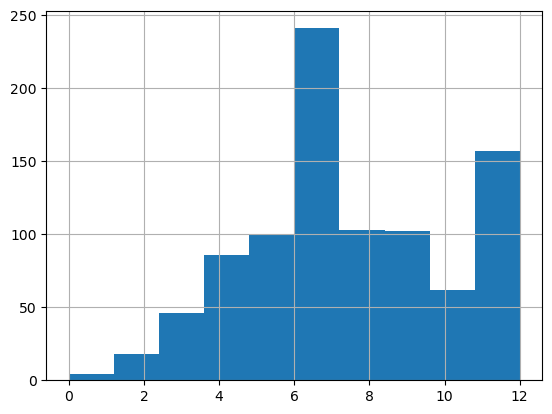

In [79]:
print(data_df.avg_expressive.hist(bins=10))

AxesSubplot(0.125,0.11;0.775x0.77)


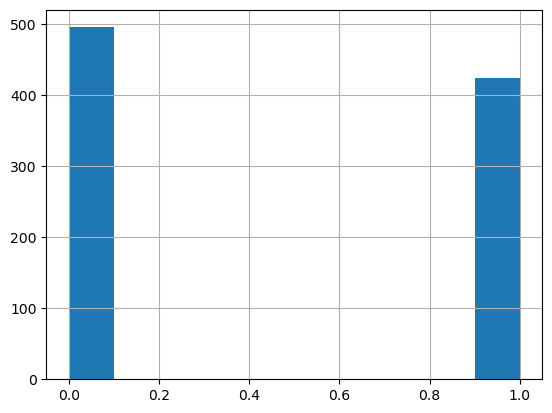

In [65]:
print(data_df.is_expressive_v0.hist(bins=10))

AxesSubplot(0.125,0.11;0.775x0.77)


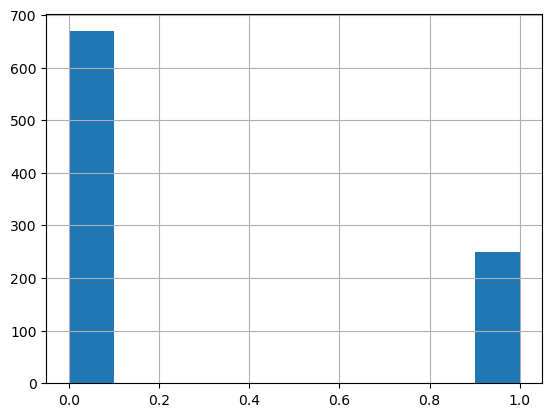

In [67]:
print(data_df.is_expressive_v1.hist(bins=10))

<AxesSubplot:>

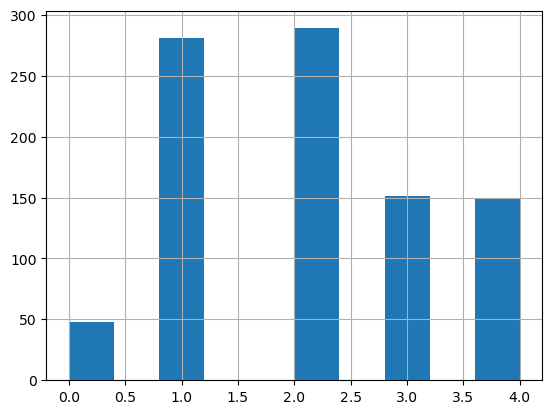

In [36]:
data_df.emotional.hist(bins=10)

<AxesSubplot:>

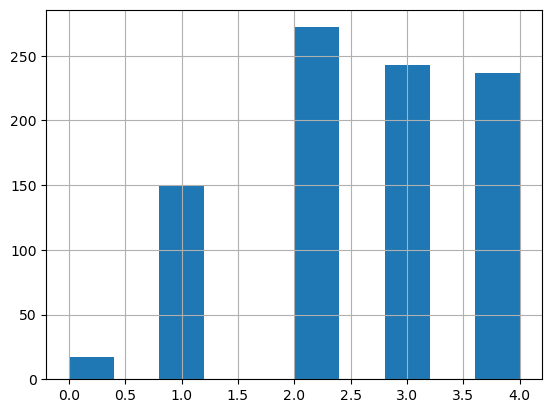

In [37]:
data_df.personal.hist(bins=10)

<AxesSubplot:>

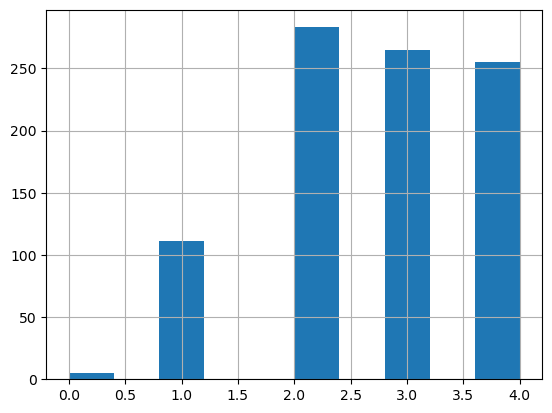

In [39]:
data_df.meaningful.hist(bins=10)

<AxesSubplot:>

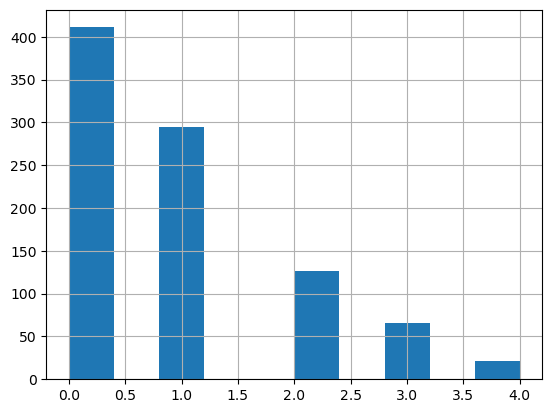

In [38]:
data_df.inhibited.hist(bins=10)

# Modeling

In [24]:
count = CountVectorizer()
word_count=count.fit_transform(data_df.plain_text)
print(word_count)

  (0, 6807)	4
  (0, 828)	1
  (0, 10108)	11
  (0, 9158)	4
  (0, 3304)	1
  (0, 4235)	2
  (0, 2541)	3
  (0, 5961)	1
  (0, 6918)	2
  (0, 1056)	25
  (0, 6784)	4
  (0, 7171)	2
  (0, 6725)	1
  (0, 9504)	9
  (0, 15495)	18
  (0, 6697)	1
  (0, 10579)	12
  (0, 1119)	2
  (0, 17330)	1
  (0, 8708)	1
  (0, 16958)	1
  (0, 15738)	11
  (0, 8414)	2
  (0, 834)	2
  (0, 13746)	7
  :	:
  (918, 7431)	1
  (918, 13900)	1
  (918, 3405)	2
  (918, 13274)	1
  (918, 960)	1
  (918, 16550)	1
  (918, 7860)	1
  (918, 9739)	1
  (918, 3654)	1
  (918, 2357)	1
  (918, 1934)	1
  (918, 946)	1
  (918, 7864)	1
  (918, 13703)	1
  (918, 15967)	1
  (918, 8944)	1
  (918, 13553)	1
  (918, 14352)	1
  (918, 10853)	1
  (918, 961)	1
  (918, 1699)	1
  (918, 3401)	1
  (918, 9681)	1
  (918, 15187)	1
  (918, 10826)	1


In [28]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count)
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=count.get_feature_names_out(),columns=["idf_weights"])

In [26]:
#inverse document frequency
df_idf.sort_values(by=['idf_weights'])

,idf_weights
to,1.029787
the,1.033152
and,1.042182
of,1.098140
for,1.100541
...,...
pictured,7.131226
aide,7.131226
flank,7.131226
flagbut,7.131226


In [31]:
#tfidf
tf_idf_vector=tfidf_transformer.transform(word_count)
feature_names = count.get_feature_names_out()
first_document_vector=tf_idf_vector[1]
df_tfifd= pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"])
df_tfifd.sort_values(by=["tfidf"],ascending=False)

,tfidf
chris,0.257194
that,0.182597
msk,0.157230
and,0.149395
she,0.146304
...,...
fairbanks,0.000000
fairing,0.000000
fairly,0.000000
fairview,0.000000


In [198]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

#stopword removal and lemmatization
stopwords = nltk.corpus.stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def custom_pre_processing(dataframe):
    dataframe = dataframe.reset_index()
    dataframe["plain_text_custproc"] = ""
    #text pre processing
    for i in range(0, len(dataframe)):
        review = re.sub('[^a-zA-Z]', ' ', dataframe.iloc[i].plain_text)
        review = review.lower()
        review = review.split()
        review = [lemmatizer.lemmatize(word) for word in review if not word in set(stopwords)]
        review = ' '.join(review)
        dataframe.loc[i, ["plain_text_custproc"]] = review
    return dataframe


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/lana/zentx005/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/lana/zentx005/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/lana/zentx005/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [202]:
data_df = custom_pre_processing(data_df)
data_df.head()

,index,pid,jid,title,plain_text,emotional,personal,meaningful,inhibited,avg_expressive,is_expressive_v0,is_expressive_v1,is_expressive_v1_1,plain_text_custproc
0,0,82100,61647de62d09e57a7bc044f2,"...the older I get, the more I see of the worl...","Good afternoon, my loves. A cloudy day, but I ...",2,4,2,0,8,1,0,0,good afternoon love cloudy day feel great god ...
1,1,46135,6164b6510921bd66bee1fedb,October isn't our favorite month,Hi All.\nWe don't really have much to update r...,3,4,4,4,11,1,1,1,hi really much update right point chris medica...
2,2,93598,6164dab3d755e845fcef9ce8,11-Oct-21,The first treatment day is complete. I spent ...,1,4,3,0,8,1,0,0,first treatment day complete spent entire day ...
3,3,82100,61662cf8153b098d31d4cf90,12-Oct-21,"Hi my loves. Today was non-stop running, so f...",0,1,0,0,1,0,0,0,hi love today non stop running first thing tom...
4,4,78146,616642eb8cd8c0d45df6f3c3,"October 12, 2021 - Anodyne",Something I didn't mention about the James Bon...,2,3,3,1,8,1,0,1,something mention james bond movie outing sund...


In [239]:
data = ['plain_text_custproc']
v0_attributes = ['is_expressive_v0']
v1_attributes = ['is_expressive_v1']

X_train, X_test, y_train, y_test = train_test_split(data_df[data], data_df[v0_attributes], train_size=0.9, random_state=2)
print(len(X_train))
print(len(X_test))

827
92


In [218]:
#tf idf
tf_idf = TfidfVectorizer() # TODO: Hyperparameter tuning for optimal parameters here.
#applying tf idf to training data
X_train_tf = tf_idf.fit_transform(X_train.plain_text_custproc.tolist())
print("n_samples: %d, n_features: %d" % X_train_tf.shape)
#applying tf idf to training data
X_test_tf = tf_idf.transform(X_test.plain_text_custproc.tolist())
print("n_samples: %d, n_features: %d" % X_test_tf.shape)

n_samples: 827, n_features: 14181
n_samples: 92, n_features: 14181


## Naive Bayes

In [227]:
#naive bayes classifier
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(X_train_tf, y_train.is_expressive_v0)
#predicted y
y_pred = naive_bayes_classifier.predict(X_test_tf)

In [228]:
print(metrics.classification_report(y_test, y_pred, target_names=['Expressive', 'Not Expressive']))
print("Confusion matrix:")
print(metrics.confusion_matrix(y_test, y_pred))

                precision    recall  f1-score   support

    Expressive       0.69      0.86      0.77        50
Not Expressive       0.77      0.55      0.64        42

      accuracy                           0.72        92
     macro avg       0.73      0.70      0.70        92
  weighted avg       0.73      0.72      0.71        92

Confusion matrix:
[[43  7]
 [19 23]]


## SVM

In [233]:
# training a linear SVM classifier
svm_model_linear = SVC(kernel = 'linear', C = 1).fit(X_train_tf, y_train.is_expressive_v0)
svm_predictions = svm_model_linear.predict(X_test_tf)

In [235]:
print(metrics.classification_report(y_test, svm_predictions, target_names=['Expressive', 'Not Expressive']))
print("Confusion matrix:")
print(metrics.confusion_matrix(y_test, svm_predictions))

                precision    recall  f1-score   support

    Expressive       0.75      0.88      0.81        50
Not Expressive       0.82      0.64      0.72        42

      accuracy                           0.77        92
     macro avg       0.78      0.76      0.76        92
  weighted avg       0.78      0.77      0.77        92

Confusion matrix:
[[44  6]
 [15 27]]


### SVM with Multi-class

In [256]:
# training a linear SVM classifier
multi_class_labels = ['meaningful_0',
                      'meaningful_1',
                      'meaningful_2',
                      'meaningful_3',
                      'meaningful_4',
                      'emotional_0',
                      'emotional_1',
                      'emotional_2',
                      'emotional_3',
                      'emotional_4',
                      'personal_0',
                      'personal_1',
                      'personal_2',
                      'personal_3',
                      'personal_4',
                     ]


X_train, X_test, y_train, y_test = train_test_split(data_df[data], data_df.meaningful, train_size=0.9, random_state=1)
print(len(X_train))
print(len(X_test))

svm_model_linear_multi = SVC(kernel = 'linear', C = 1).fit(X_train_tf, y_train)
svm_predictions = svm_model_linear_multi.predict(X_test_tf)

827
92


In [253]:
print(metrics.classification_report(y_test, svm_predictions, target_names=['0', '1', '2', '3', '4']))
print("Confusion matrix:")
print(metrics.confusion_matrix(y_test, svm_predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       1.00      0.07      0.12        15
           2       0.30      0.60      0.40        25
           3       0.50      0.27      0.35        33
           4       0.22      0.28      0.24        18

    accuracy                           0.33        92
   macro avg       0.40      0.24      0.22        92
weighted avg       0.47      0.33      0.30        92

Confusion matrix:
[[ 0  0  1  0  0]
 [ 0  1  6  3  5]
 [ 0  0 15  4  6]
 [ 0  0 17  9  7]
 [ 0  0 11  2  5]]


/home/lana/shared/bin/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lana/shared/bin/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lana/shared/bin/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [257]:
X_train, X_test, y_train, y_test = train_test_split(data_df[data], data_df.emotional, train_size=0.9, random_state=1)
print(len(X_train))
print(len(X_test))

svm_model_linear_multi = SVC(kernel = 'linear', C = 1).fit(X_train_tf, y_train)
svm_predictions = svm_model_linear_multi.predict(X_test_tf)

print(metrics.classification_report(y_test, svm_predictions, target_names=['0', '1', '2', '3', '4']))
print("Confusion matrix:")
print(metrics.confusion_matrix(y_test, svm_predictions))

827
92
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.34      0.41      0.37        34
           2       0.30      0.46      0.36        28
           3       0.25      0.08      0.12        13
           4       0.00      0.00      0.00        11

    accuracy                           0.30        92
   macro avg       0.18      0.19      0.17        92
weighted avg       0.25      0.30      0.26        92

Confusion matrix:
[[ 0  4  2  0  0]
 [ 1 14 17  0  2]
 [ 0 13 13  2  0]
 [ 0  7  5  1  0]
 [ 0  3  7  1  0]]


In [258]:
X_train, X_test, y_train, y_test = train_test_split(data_df[data], data_df.personal, train_size=0.9, random_state=1)
print(len(X_train))
print(len(X_test))

svm_model_linear_multi = SVC(kernel = 'linear', C = 1).fit(X_train_tf, y_train)
svm_predictions = svm_model_linear_multi.predict(X_test_tf)

print(metrics.classification_report(y_test, svm_predictions, target_names=['0', '1', '2', '3', '4']))
print("Confusion matrix:")
print(metrics.confusion_matrix(y_test, svm_predictions))

827
92
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00        18
           2       0.26      0.55      0.35        22
           3       0.32      0.26      0.29        27
           4       0.14      0.14      0.14        22

    accuracy                           0.24        92
   macro avg       0.14      0.19      0.15        92
weighted avg       0.19      0.24      0.20        92

Confusion matrix:
[[ 0  1  2  0  0]
 [ 0  0  9  3  6]
 [ 0  0 12  5  5]
 [ 0  0 12  7  8]
 [ 0  0 12  7  3]]


/home/lana/shared/bin/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lana/shared/bin/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lana/shared/bin/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
